error_L2  = 0.008558164961018003
error_max = 1.11022302463e-15


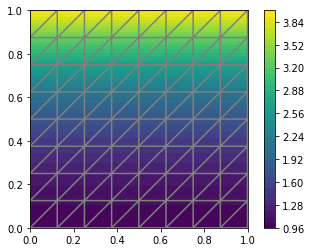

[ 4.        3.296875  4.        2.6875    3.296875  4.        2.171875
  2.6875    3.296875  4.        1.75      2.171875  2.6875    3.296875  4.
  1.421875  1.75      2.171875  2.6875    3.296875  4.        1.1875
  1.421875  1.75      2.171875  2.6875    3.296875  4.        1.046875
  1.1875    1.421875  1.75      2.171875  2.6875    3.296875  4.        1.
  1.046875  1.1875    1.421875  1.75      2.171875  2.6875    3.296875  4.
  1.        1.046875  1.1875    1.421875  1.75      2.171875  2.6875
  3.296875  1.        1.046875  1.1875    1.421875  1.75      2.171875
  2.6875    1.        1.046875  1.1875    1.421875  1.75      2.171875  1.
  1.046875  1.1875    1.421875  1.75      1.        1.046875  1.1875
  1.421875  1.        1.046875  1.1875    1.        1.046875  1.      ]


In [46]:
#standard 2d version
"""
FEniCS tutorial demo program: Poisson equation with Dirichlet conditions.
Test problem is chosen to give an exact solution at all nodes of the mesh.
-Laplace(u) = f    in the unit square
u = u_D  on the boundary
u_D = 1 + 3y^2
f = -6
"""
from __future__ import print_function
#from fenics import *
import dolfin as dl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# Create mesh and define function space
mesh = dl.UnitSquareMesh(8, 8)
V = dl.FunctionSpace(mesh, 'P', 1)

# Define boundary condition
#u_D = dl.Expression('1 + x[0]*x[0] + 2*x[1]*x[1]', degree=2)
#try a simpler one
u_D = dl.Expression('1  + 3*x[1]*x[1]', degree=2)
def boundary(x, on_boundary):
    return on_boundary
bc = dl.DirichletBC(V, u_D, boundary)
# Define variational problem
u = dl.TrialFunction(V)
v = dl.TestFunction(V)
f = dl.Constant(-6.0)
a = dl.dot(dl.grad(u), dl.grad(v))*dl.dx
L = f*v*dl.dx

# Compute solution
u = dl.Function(V)
dl.solve(a == L, u, bc)

# Plot solution and mesh
cm=dl.plot(u)
dl.plot(mesh)
plt.colorbar(cm)
# Save solution to file in VTK format
#vtkfile = File('poisson/solution.pvd')
#vtkfile << u

# Compute error in L2 norm
error_L2 = dl.errornorm(u_D, u, 'L2')

# Compute maximum error at vertices
vertex_values_u_D = u_D.compute_vertex_values(mesh)
vertex_values_u = u.compute_vertex_values(mesh)

error_max = np.max(np.abs(vertex_values_u_D - vertex_values_u))

# Print errors
print('error_L2  =', error_L2)
print('error_max =', error_max)

# Hold plot
#interactive()
plt.show()
print(u.vector()[:])

In [47]:
def cartesian_product(array1,array2):
    #gives cartesian product of 2 vectors
    dim1=len(array1)
    dim2=len(array2)
    out_arr=np.zeros((dim1*dim2,2))
    c=0
    for a in range(dim1):
        for b in range(dim2):
            out_arr[c,:]=[array1[a],array2[b]]
            c=c+1
    return out_arr
def cartesian_form_to_kroneck_form(indeces, len_dim_2):
    #designed to take list of indexes in the cartesian form
    #translate to single form as kron product would
    #only for cartesian product between 2 spaces
    #expects matrix with n rows, 2 columns
    num_indeces=indeces.shape[0]
    out_arr=np.zeros(num_indeces)
    for n in range(num_indeces):
        out_arr[n] = indeces[n,0]*len_dim_2 + indeces[n,1]
    return out_arr

In [48]:
#cartesian product of 2 1-d domains with dirichlet boundary
mesh1 = dl.UnitIntervalMesh(8)
mesh2 = dl.UnitIntervalMesh(8)

#create function spaces for each piece
V1 = dl.FunctionSpace(mesh1, 'P', 1)
V2 = dl.FunctionSpace(mesh2, 'P', 1)

#create trial and test functions
u1_trial = dl.TrialFunction(V1)
v1_test = dl.TestFunction(V1)
u2_trial = dl.TrialFunction(V2)
v2_test = dl.TestFunction(V2)

#assemble weak forms (more complex due to chain rule)
stiffness_form11 = dl.inner(dl.grad(u1_trial), dl.grad(v1_test)) * dl.dx
stiffness_form12 = u1_trial*v1_test* dl.dx

stiffness_form21 = dl.inner(dl.grad(u2_trial), dl.grad(v2_test)) * dl.dx
stiffness_form22 = u2_trial*v2_test * dl.dx

#assign right hand side
f = dl.Constant(-6.0)


#assemble stiffness matrices (only will work for linear forms)
K11 = dl.assemble(stiffness_form11)
K12 = dl.assemble(stiffness_form12)
K21 = dl.assemble(stiffness_form21) 
K22 = dl.assemble(stiffness_form22)


#assign right hand sides (will need to generalize later)
rhs_form1 = v1_test * dl.dx
rhs_form2 = f * v2_test * dl.dx
b1 = dl.assemble(rhs_form1)
b2 = dl.assemble(rhs_form2)

#use this to mark boundary (Dirichlet) 
#This is actual what boundary we want to apply
#u_D2 = dl.Expression('1  + 3*x[0]*x[0]', degree=2)
def boundary(x, on_boundary):
    return on_boundary

#u_D = u_D1*u_D2
u_D1 = dl.Expression('1.0', degree=2)


#establish dummy functions
dum1=dl.Function(V1)
dum2=dl.Function(V2)



bc1 = dl.DirichletBC(V1, u_D1, boundary)
bc2 = dl.DirichletBC(V2, u_D1, boundary)

bc1.apply(dum1.vector())
bc2.apply(dum2.vector())

#get index number for each boundary cooordinate
boundary_dofs1 = np.where(dum1.vector()==1.0)[0]
boundary_dofs2 = np.where(dum2.vector()==1.0)[0]

#indeces of boundaries in subdomains
print(boundary_dofs1)
print(boundary_dofs2)

#need all boundary coordinates in case we need for calculations
dof_coordinates1=V1.tabulate_dof_coordinates()
dof_coordinates2=V1.tabulate_dof_coordinates()
#physical coordinates should be just cartesian product of 2 dof maps in same order that kron product operates
global_dof=cartesian_product(dof_coordinates1,dof_coordinates2)

#coordinates of boundary in each subdomain
boundary_coord1 = dof_coordinates1[boundary_dofs1]
boundary_coord2 = dof_coordinates2[boundary_dofs2]

print(dof_coordinates2.shape)
#now connect subdomain indeces to global boundary (turn this into function)
#maybe in future for speed we can precompute number of boundary dofs
global_boundary_dofs=np.empty((len(boundary_dofs1)*len(dof_coordinates2) + len(dof_coordinates1)*len(boundary_dofs2),2))

ctr=0
for j in boundary_dofs1:
    global_boundary_dofs[ctr*len(dof_coordinates2):(ctr+1)*len(dof_coordinates2),:] = \
    cartesian_product(np.array([j]),np.arange(dof_coordinates2.shape[0]))
    ctr=ctr+1
    
last_ind = (ctr)*len(dof_coordinates2)


for j in boundary_dofs2:
    global_boundary_dofs[last_ind:last_ind+len(dof_coordinates2),:] = \
    cartesian_product(np.arange(dof_coordinates1.shape[0]),np.array([j]))
    last_ind = last_ind+len(dof_coordinates2)    


#sorts and also eliminates duplicates of "corners"
global_boundary_dofs=np.unique(global_boundary_dofs,axis=0)
print(global_boundary_dofs)

#have cartesian product of dof at entire boundary (this form should be easy to get coordinates in if needed)
#now need to convert to global system dof as the kron function does
global_boundary_dofs=cartesian_form_to_kroneck_form(global_boundary_dofs, len(dof_coordinates2))
global_boundary_dofs=global_boundary_dofs.astype(int)

print(global_boundary_dofs)


#assemble global system using kronecker product
K11 = np.array(K11.array())
K12 = np.array(K12.array())
K21 = np.array(K21.array())
K22 = np.array(K22.array())

A=np.kron(K11,K22) + np.kron(K12,K21)
print(A)



b1 = np.array(b1)
b2 = np.array(b2)
B=np.kron(b1,b2)

#need to apply bcs using boundary_dofs info
#set the rows in the boundary to 1 on diagonal
K_bound = np.zeros(A.shape)
for i in global_boundary_dofs:
    K_bound[i,i] = 1

A[global_boundary_dofs,:] = K_bound[global_boundary_dofs,:]
print(A)

#set the value of solution on boundary as rhs
B[global_boundary_dofs] = 1+3*global_dof[global_boundary_dofs,1]**2

#solve global system
u=np.zeros(len(B))

#solve(A,u,B)
u=np.linalg.solve(A,B)



Calling FFC just-in-time (JIT) compiler, this may take some time.
[0 8]
[0 8]
(9, 1)
[[ 0.  0.]
 [ 0.  1.]
 [ 0.  2.]
 [ 0.  3.]
 [ 0.  4.]
 [ 0.  5.]
 [ 0.  6.]
 [ 0.  7.]
 [ 0.  8.]
 [ 1.  0.]
 [ 1.  8.]
 [ 2.  0.]
 [ 2.  8.]
 [ 3.  0.]
 [ 3.  8.]
 [ 4.  0.]
 [ 4.  8.]
 [ 5.  0.]
 [ 5.  8.]
 [ 6.  0.]
 [ 6.  8.]
 [ 7.  0.]
 [ 7.  8.]
 [ 8.  0.]
 [ 8.  1.]
 [ 8.  2.]
 [ 8.  3.]
 [ 8.  4.]
 [ 8.  5.]
 [ 8.  6.]
 [ 8.  7.]
 [ 8.  8.]]
[ 0  1  2  3  4  5  6  7  8  9 17 18 26 27 35 36 44 45 53 54 62 63 71 72 73
 74 75 76 77 78 79 80]
[[ 0.66666667 -0.16666667  0.         ...,  0.          0.          0.        ]
 [-0.16666667  1.33333333 -0.16666667 ...,  0.          0.          0.        ]
 [ 0.         -0.16666667  1.33333333 ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  1.33333333 -0.16666667  0.        ]
 [ 0.          0.          0.         ..., -0.16666667  1.33333333
  -0.16666667]
 [ 0.          0.          0.         ...,  0.        

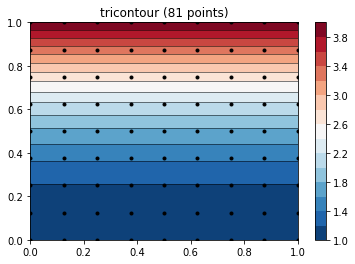

[ 4.        3.296875  2.6875    2.171875  1.75      1.421875  1.1875
  1.046875  1.        4.        3.296875  2.6875    2.171875  1.75
  1.421875  1.1875    1.046875  1.        4.        3.296875  2.6875
  2.171875  1.75      1.421875  1.1875    1.046875  1.        4.        3.296875
  2.6875    2.171875  1.75      1.421875  1.1875    1.046875  1.        4.
  3.296875  2.6875    2.171875  1.75      1.421875  1.1875    1.046875  1.
  4.        3.296875  2.6875    2.171875  1.75      1.421875  1.1875
  1.046875  1.        4.        3.296875  2.6875    2.171875  1.75
  1.421875  1.1875    1.046875  1.        4.        3.296875  2.6875
  2.171875  1.75      1.421875  1.1875    1.046875  1.        4.        3.296875
  2.6875    2.171875  1.75      1.421875  1.1875    1.046875  1.      ]


In [49]:
#now find way to plot (we know we have regular grid in this case)
fig,  ax2 = plt.subplots(nrows=1)

ax2.tricontour(global_dof[:,0], global_dof[:,1], u, levels=14, linewidths=0.5, colors='k')
cntr2 = ax2.tricontourf(global_dof[:,0], global_dof[:,1], u, levels=14, cmap="RdBu_r")

fig.colorbar(cntr2, ax=ax2)
ax2.plot(global_dof[:,0], global_dof[:,1], 'ko', ms=3)
ax2.set(xlim=(0, 1), ylim=(0, 1))
ax2.set_title('tricontour (%d points)' % len(u))

plt.subplots_adjust(hspace=0.5)
plt.show()

print(u)

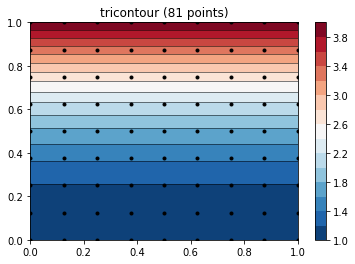

[ 4.        3.296875  2.6875    2.171875  1.75      1.421875  1.1875
  1.046875  1.        4.        3.296875  2.6875    2.171875  1.75
  1.421875  1.1875    1.046875  1.        4.        3.296875  2.6875
  2.171875  1.75      1.421875  1.1875    1.046875  1.        4.        3.296875
  2.6875    2.171875  1.75      1.421875  1.1875    1.046875  1.        4.
  3.296875  2.6875    2.171875  1.75      1.421875  1.1875    1.046875  1.
  4.        3.296875  2.6875    2.171875  1.75      1.421875  1.1875
  1.046875  1.        4.        3.296875  2.6875    2.171875  1.75
  1.421875  1.1875    1.046875  1.        4.        3.296875  2.6875
  2.171875  1.75      1.421875  1.1875    1.046875  1.        4.        3.296875
  2.6875    2.171875  1.75      1.421875  1.1875    1.046875  1.      ]


In [50]:
#plot analytic solution
#now find way to plot (we know we have regular grid in this case)
fig,  ax2 = plt.subplots(nrows=1)

u_true = 1 + 3*global_dof[:,1]**2

ax2.tricontour(global_dof[:,0], global_dof[:,1], u_true, levels=14, linewidths=0.5, colors='k')
cntr2 = ax2.tricontourf(global_dof[:,0], global_dof[:,1], u_true, levels=14, cmap="RdBu_r")

fig.colorbar(cntr2, ax=ax2)
ax2.plot(global_dof[:,0], global_dof[:,1], 'ko', ms=3)
ax2.set(xlim=(0, 1), ylim=(0, 1))
ax2.set_title('tricontour (%d points)' % len(u))

plt.subplots_adjust(hspace=0.5)
plt.show()
print(u_true)

In [51]:
print(u-u_true)

[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00  -8.88178420e-16
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
  -8.88178420e-16  -4.44089210e-16  -2.22044605e-16   0.00000000e+00
   0.00000000e+00   2.22044605e-16   0.00000000e+00   0.00000000e+00
  -4.44089210e-16   0.00000000e+00  -8.88178420e-16   0.00000000e+00
   2.22044605e-16  -2.22044605e-16  -2.22044605e-16   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -4.44089210e-16  -4.44089210e-16
   2.22044605e-16   2.22044605e-16  -2.22044605e-16  -2.22044605e-16
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.44089210e-16
  -4.44089210e-16  -2.22044605e-16   0.00000000e+00   0.00000000e+00
  -4.44089210e-16   0.00000000e+00   0.00000000e+00   8.88178420e-16
   0.00000000e+00   0.00000000e+00